In [1]:
!pip install timm

     |████████████████████████████████| 247 kB 416 kB/s eta 0:00:01


In [2]:
import torch
import timm
import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
import torchvision
import torchvision.transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

# Read the data

In [3]:
def read_bboxes(filepath):
    bboxes = {}
    with open(filepath, mode='r') as f:
        reader = csv.reader(f)
        bboxes = {row[0]: {'x_min': float(row[1]), 'y_min': float(row[2]), 'x_max': float(row[3]), 'y_max': float(row[4])} for row in reader}
    return bboxes

bboxes = read_bboxes('/kaggle/input/bird-dataset-bboxes/test_images_bboxes.csv')
bboxes = {**bboxes, **read_bboxes('/kaggle/input/bird-dataset-bboxes/train_images_new_split_bboxes.csv')}
bboxes = {**bboxes, **read_bboxes('/kaggle/input/bird-dataset-bboxes/val_images_new_split_bboxes.csv')}

dataset_path = '/kaggle/input/mva-recvis-2020/bird_dataset'
classes = os.listdir(f'{dataset_path}/train_images')
classes = sorted(classes)

val_image_list = []
val_label_list = []
train_image_list = []
train_label_list = []
train_bbox_list = []
val_bbox_list = []

for label, c in tqdm(enumerate(classes)):
    val_images = sorted(os.listdir(f'{dataset_path}/val_images/{c}'))
    train_images = sorted(os.listdir(f'{dataset_path}/train_images/{c}'))
    val_images = [f'{dataset_path}/val_images/{c}/{f}' for f in val_images]
    train_images = [f'{dataset_path}/train_images/{c}/{f}' for f in train_images]
    n = 20-len(val_images)
    val_images = val_images + train_images[:n]
    train_images = train_images[n:]
    for f in val_images:
        image = PIL.Image.open(f).convert('RGB')
        val_image_list.append(image)
        val_label_list.append(label)
        val_bbox_list.append(bboxes[os.path.basename(f)])
    for f in train_images:
        image = PIL.Image.open(f).convert('RGB')
        train_image_list.append(image)
        train_label_list.append(label)
        train_bbox_list.append(bboxes[os.path.basename(f)])

20it [00:08,  2.41it/s]


# Choose feature extractor

In [4]:
device = 'cuda'

In [120]:
feature_extractor = timm.create_model('tf_efficientnet_b5_ns', pretrained=True, num_classes=0, global_pool='')
feature_extractor.to(device)
feature_extractor.eval()
feature_extractor.default_cfg

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth',
 'num_classes': 1000,
 'input_size': (3, 456, 456),
 'pool_size': (15, 15),
 'crop_pct': 0.934,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

# Preprocessing

In [7]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, bboxes=None, image_size=None, crop_margin=0.05, transform=None, preserve_aspect_ratio=False, **kwargs):
        super(ImageDataset, self).__init__(**kwargs)
        self.images = images
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform
        self.crop_margin = crop_margin
        self.image_size = image_size
        self.preserve_aspect_ratio = preserve_aspect_ratio
        
    def crop(self, image, bbox):
        
        x_min, y_min, x_max, y_max = bbox['x_min'], bbox['y_min'], bbox['x_max'], bbox['y_max']
        x_min = float(x_min)
        y_min = float(y_min)
        x_max = float(x_max)
        y_max = float(y_max)
        
        width, height = image.size
        
        x_min = max(0, x_min)
        x_max = min(width-1, x_max)
        y_min = max(0, y_min)
        y_max = min(height-1, y_max)
        
        if x_max - x_min < 5 or y_max - y_min < 5: # unreliable bbox
            x_min = 0
            x_max = width-1
            y_min = 0
            y_max = height-1
        
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
            
        margin = self.crop_margin
        x_min -= margin * bbox_width
        x_max += margin * bbox_width
        y_min -= margin * bbox_height
        y_max += margin * bbox_height
        
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
        x_min = max(0, x_min)
        x_max = min(width-1, x_max)
        y_min = max(0, y_min)
        y_max = min(height-1, y_max)
        
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        
        # extend box to get a square
        if bbox_width > bbox_height:
            s_min = y_min
            s_max = y_max
            l = y_max - y_min
            L = bbox_width
            LL = height
        else:
            s_min = x_min
            s_max = x_max
            l = x_max - x_min
            L = bbox_height
            LL = width
        e_min = s_min - (L-l)//2
        e_max = s_max + (L-l)//2
        e_min = max(e_min, 0)
        e_max = min(e_max, LL-1)
        l_ = e_max-e_min
        e_min -= L - l_
        e_max += L - l_
        e_min = max(e_min, 0)
        e_max = min(e_max, LL-1)
        l_ = e_max-e_min
        #e_min -= (L-l_)//2
        #e_max = e_min+L
        if bbox_width > bbox_height:
            y_min = e_min
            y_max = e_max
        else:
            x_min = e_min
            x_max = e_max
        
        crop = image.crop((x_min, y_min, x_max, y_max))
        
        if self.image_size is not None:
            if self.preserve_aspect_ratio:
                width, height = crop.size
                scale = self.image_size / max(width, height)
                crop = crop.resize((round(width*scale), round(height*scale)), PIL.Image.BICUBIC)
            else:
                crop = crop.resize((self.image_size, self.image_size), PIL.Image.BICUBIC)
        
        return crop
    
    def __getitem__(self, index):
        image = self.images[index]
        if self.bboxes is not None:
            image = self.crop(image, self.bboxes[index])
        if self.transform:
            image = self.transform(image)
        label = self.labels[index]
        return image, label
    def __len__(self):
        return len(self.labels)
    

In [122]:
mean, std = feature_extractor.default_cfg['mean'], feature_extractor.default_cfg['std']
image_size = feature_extractor.default_cfg['input_size'][1]

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

params = {
    'transform': transform,
    'crop_margin': 0.1,
    'image_size': image_size,
    'preserve_aspect_ratio': False
}

train_dataset = ImageDataset(train_image_list, train_label_list, bboxes=train_bbox_list, **params)
val_dataset = ImageDataset(val_image_list, val_label_list, bboxes=val_bbox_list, **params)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, drop_last=False)

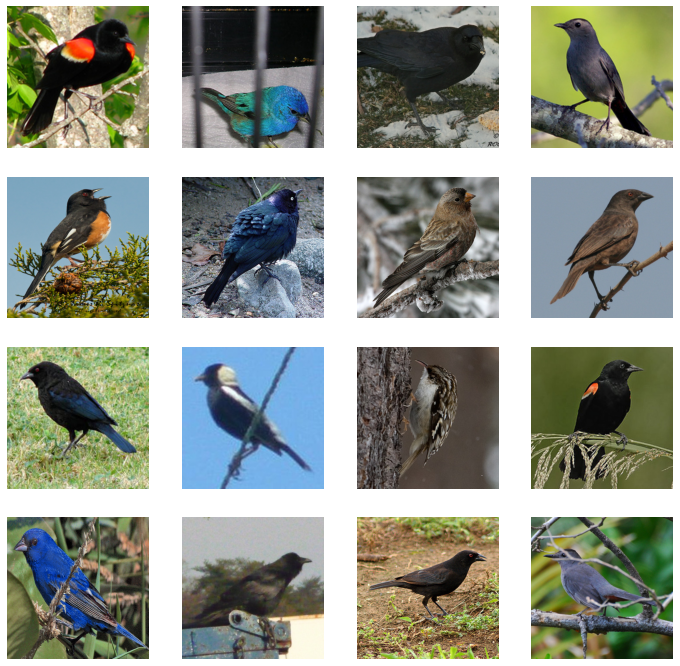

In [125]:
_, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()
for i, (image, label) in enumerate(train_loader):
    if i == 16: break
    axes[i].axis('off')
    axes[i].imshow(image.squeeze().permute(1, 2, 0)*np.array(std) + np.array(mean))

In [126]:
features_train = []
features_val = []
labels_train = []
labels_val = []
with torch.no_grad():
    for image, label in tqdm(train_loader):
        x = feature_extractor(image.to(device))
        features_train.append(x)
        labels_train.append(label)
    for image, label in tqdm(val_loader):
        x = feature_extractor(image.to(device))
        features_val.append(x)
        labels_val.append(label)
features_train = torch.cat(features_train, dim=0)
features_val = torch.cat(features_val, dim=0)
labels_train = torch.cat(labels_train, dim=0)
labels_val = torch.cat(labels_val, dim=0)

100%|██████████| 400/400 [00:15<00:00, 25.56it/s]


# Cosine classification

In [127]:
embeddings_train = torch.mean(features_train, dim=(2, 3))
embeddings_val = torch.mean(features_val, dim=(2, 3))

# L2 classification
prototypes = []
for c in range(20):
    prototypes.append(embeddings_train[labels_train==c].mean(dim=0))
prototypes = torch.stack(prototypes, dim=1)
distances = (embeddings_val[..., None] - prototypes[None, ...]).square().sum(dim=1)
predictions = distances.argmin(dim=1)
accuracy = (predictions == labels_val.to(device)).double().mean()
print(f'L2 accuracy: {accuracy.item():.4f}')

# Cosine similarity classification
prototypes = []
for c in range(20):
    prototypes.append(F.normalize(embeddings_train[labels_train==c], dim=1).mean(dim=0))
prototypes = torch.stack(prototypes, dim=1)
prototypes = F.normalize(prototypes, dim=0)
similarities = F.normalize(embeddings_val, dim=1).mm(prototypes)
predictions = similarities.argmax(dim=1)
accuracy = (predictions == labels_val.to(device)).double().mean()
print(f'CC accuracy: {accuracy.item():.4f}')

L2 accuracy: 0.8950
CC accuracy: 0.8950


# Training a small neural network on the features

In [128]:
class NN(nn.Module):
    def __init__(self, in_channels):
        super(NN, self).__init__()
        num_features = 512
        self.conv = nn.Conv2d(in_channels, num_features, 3)
        self.bn = nn.BatchNorm2d(num_features)
        self.linear = nn.Linear(num_features, 20)
    def forward(self, x):
        x = F.dropout(x, p=0.5)
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = F.adaptive_max_pool2d(x, output_size=1).squeeze()
        x = F.dropout(x, p=0.5)
        x = self.linear(x)
        return x
    
model = NN(in_channels=features_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [130]:
td = torch.utils.data.TensorDataset(features_train.to('cpu'), labels_train)
vd = torch.utils.data.TensorDataset(features_val.to('cpu'), labels_val)
train_loader = torch.utils.data.DataLoader(td, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
val_loader   = torch.utils.data.DataLoader(vd, batch_size=32, shuffle=True, num_workers=2, drop_last=False)

In [136]:
best_accuracy = 0.

for epoch in range(1, 400+1):
    print('\nEpoch', epoch)
    
    model.train()
    
    total_loss = 0.0
    num_samples = 0.0
    correct = []
    for i, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.size(0)
        num_samples += data.size(0)
        correct.append(output.argmax(dim=1) == target)
                
    correct = torch.cat(correct, dim=0)
    accuracy = correct.double().mean().item()
    total_loss /= num_samples
    train_loss = total_loss
    train_accuracy = accuracy
        
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        num_samples = 0.0
        correct = []
        for i, (data, target) in enumerate(val_loader):

            data = data.to(device)
            target = target.to(device)
        
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
        
            total_loss += loss.item() * data.size(0)
            num_samples += data.size(0)
            correct.append(output.argmax(dim=1) == target)
                
        correct = torch.cat(correct, dim=0)
        accuracy = correct.double().mean().item()
        best_accuracy = max(best_accuracy, accuracy)
        total_loss /= num_samples
        
        print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
        print(f'Valid loss: {total_loss:.4f}, Valid accuracy: {accuracy:.4f}')
        print(f'Best accuracy so far: {best_accuracy:.4f}')


Epoch 1
Train loss: 0.0007, Train accuracy: 1.0000
Valid loss: 0.3804, Valid accuracy: 0.9325
Best accuracy so far: 0.9325

Epoch 2
Train loss: 0.0006, Train accuracy: 1.0000
Valid loss: 0.3703, Valid accuracy: 0.9150
Best accuracy so far: 0.9325

Epoch 3
Train loss: 0.0024, Train accuracy: 0.9987
Valid loss: 0.4046, Valid accuracy: 0.9250
Best accuracy so far: 0.9325

Epoch 4
Train loss: 0.0011, Train accuracy: 1.0000
Valid loss: 0.3124, Valid accuracy: 0.9325
Best accuracy so far: 0.9325

Epoch 5
Train loss: 0.0003, Train accuracy: 1.0000
Valid loss: 0.3888, Valid accuracy: 0.9325
Best accuracy so far: 0.9325

Epoch 6
Train loss: 0.0014, Train accuracy: 1.0000
Valid loss: 0.3558, Valid accuracy: 0.9200
Best accuracy so far: 0.9325

Epoch 7
Train loss: 0.0015, Train accuracy: 1.0000
Valid loss: 0.3069, Valid accuracy: 0.9375
Best accuracy so far: 0.9375

Epoch 8
Train loss: 0.0004, Train accuracy: 1.0000
Valid loss: 0.3688, Valid accuracy: 0.9225
Best accuracy so far: 0.9375

Epoch 9

Train loss: 0.0005, Train accuracy: 1.0000
Valid loss: 0.2552, Valid accuracy: 0.9425
Best accuracy so far: 0.9450

Epoch 68
Train loss: 0.0027, Train accuracy: 0.9987
Valid loss: 0.3569, Valid accuracy: 0.9275
Best accuracy so far: 0.9450

Epoch 69
Train loss: 0.0006, Train accuracy: 1.0000
Valid loss: 0.4010, Valid accuracy: 0.9300
Best accuracy so far: 0.9450

Epoch 70
Train loss: 0.0007, Train accuracy: 1.0000
Valid loss: 0.3512, Valid accuracy: 0.9200
Best accuracy so far: 0.9450

Epoch 71
Train loss: 0.0008, Train accuracy: 1.0000
Valid loss: 0.2815, Valid accuracy: 0.9400
Best accuracy so far: 0.9450

Epoch 72
Train loss: 0.0031, Train accuracy: 0.9987
Valid loss: 0.3773, Valid accuracy: 0.9300
Best accuracy so far: 0.9450

Epoch 73
Train loss: 0.0007, Train accuracy: 1.0000
Valid loss: 0.2913, Valid accuracy: 0.9275
Best accuracy so far: 0.9450

Epoch 74
Train loss: 0.0013, Train accuracy: 1.0000
Valid loss: 0.3342, Valid accuracy: 0.9250
Best accuracy so far: 0.9450

Epoch 75


Train loss: 0.0009, Train accuracy: 1.0000
Valid loss: 0.2784, Valid accuracy: 0.9375
Best accuracy so far: 0.9475

Epoch 134
Train loss: 0.0013, Train accuracy: 1.0000
Valid loss: 0.3179, Valid accuracy: 0.9325
Best accuracy so far: 0.9475

Epoch 135
Train loss: 0.0007, Train accuracy: 1.0000
Valid loss: 0.3978, Valid accuracy: 0.9275
Best accuracy so far: 0.9475

Epoch 136
Train loss: 0.0015, Train accuracy: 1.0000
Valid loss: 0.3017, Valid accuracy: 0.9450
Best accuracy so far: 0.9475

Epoch 137
Train loss: 0.0007, Train accuracy: 1.0000
Valid loss: 0.3501, Valid accuracy: 0.9225
Best accuracy so far: 0.9475

Epoch 138
Train loss: 0.0009, Train accuracy: 1.0000
Valid loss: 0.3253, Valid accuracy: 0.9325
Best accuracy so far: 0.9475

Epoch 139
Train loss: 0.0007, Train accuracy: 1.0000
Valid loss: 0.3631, Valid accuracy: 0.9325
Best accuracy so far: 0.9475

Epoch 140
Train loss: 0.0014, Train accuracy: 1.0000
Valid loss: 0.2948, Valid accuracy: 0.9300
Best accuracy so far: 0.9475

Ep

Train loss: 0.0011, Train accuracy: 1.0000
Valid loss: 0.3433, Valid accuracy: 0.9275
Best accuracy so far: 0.9475

Epoch 200
Train loss: 0.0004, Train accuracy: 1.0000
Valid loss: 0.3788, Valid accuracy: 0.9150
Best accuracy so far: 0.9475

Epoch 201
Train loss: 0.0005, Train accuracy: 1.0000
Valid loss: 0.3279, Valid accuracy: 0.9300
Best accuracy so far: 0.9475

Epoch 202
Train loss: 0.0021, Train accuracy: 0.9987
Valid loss: 0.3118, Valid accuracy: 0.9350
Best accuracy so far: 0.9475

Epoch 203
Train loss: 0.0003, Train accuracy: 1.0000
Valid loss: 0.2998, Valid accuracy: 0.9325
Best accuracy so far: 0.9475

Epoch 204
Train loss: 0.0015, Train accuracy: 1.0000
Valid loss: 0.3275, Valid accuracy: 0.9300
Best accuracy so far: 0.9475

Epoch 205
Train loss: 0.0006, Train accuracy: 1.0000
Valid loss: 0.3729, Valid accuracy: 0.9250
Best accuracy so far: 0.9475

Epoch 206
Train loss: 0.0008, Train accuracy: 1.0000
Valid loss: 0.3134, Valid accuracy: 0.9275
Best accuracy so far: 0.9475

Ep

Train loss: 0.0007, Train accuracy: 1.0000
Valid loss: 0.3532, Valid accuracy: 0.9375
Best accuracy so far: 0.9475

Epoch 266
Train loss: 0.0006, Train accuracy: 1.0000
Valid loss: 0.3447, Valid accuracy: 0.9375
Best accuracy so far: 0.9475

Epoch 267
Train loss: 0.0005, Train accuracy: 1.0000
Valid loss: 0.3020, Valid accuracy: 0.9225
Best accuracy so far: 0.9475

Epoch 268
Train loss: 0.0007, Train accuracy: 1.0000
Valid loss: 0.3922, Valid accuracy: 0.9250
Best accuracy so far: 0.9475

Epoch 269
Train loss: 0.0003, Train accuracy: 1.0000
Valid loss: 0.2694, Valid accuracy: 0.9200
Best accuracy so far: 0.9475

Epoch 270
Train loss: 0.0005, Train accuracy: 1.0000
Valid loss: 0.3557, Valid accuracy: 0.9300
Best accuracy so far: 0.9475

Epoch 271
Train loss: 0.0008, Train accuracy: 1.0000
Valid loss: 0.3423, Valid accuracy: 0.9275
Best accuracy so far: 0.9475

Epoch 272
Train loss: 0.0008, Train accuracy: 1.0000
Valid loss: 0.3084, Valid accuracy: 0.9425
Best accuracy so far: 0.9475

Ep

Train loss: 0.0009, Train accuracy: 1.0000
Valid loss: 0.3263, Valid accuracy: 0.9400
Best accuracy so far: 0.9525

Epoch 332
Train loss: 0.0004, Train accuracy: 1.0000
Valid loss: 0.3884, Valid accuracy: 0.9250
Best accuracy so far: 0.9525

Epoch 333
Train loss: 0.0004, Train accuracy: 1.0000
Valid loss: 0.3193, Valid accuracy: 0.9350
Best accuracy so far: 0.9525

Epoch 334
Train loss: 0.0020, Train accuracy: 0.9987
Valid loss: 0.3181, Valid accuracy: 0.9275
Best accuracy so far: 0.9525

Epoch 335
Train loss: 0.0012, Train accuracy: 1.0000
Valid loss: 0.3449, Valid accuracy: 0.9300
Best accuracy so far: 0.9525

Epoch 336
Train loss: 0.0002, Train accuracy: 1.0000
Valid loss: 0.3975, Valid accuracy: 0.9200
Best accuracy so far: 0.9525

Epoch 337
Train loss: 0.0006, Train accuracy: 1.0000
Valid loss: 0.3995, Valid accuracy: 0.9250
Best accuracy so far: 0.9525

Epoch 338
Train loss: 0.0014, Train accuracy: 1.0000
Valid loss: 0.3329, Valid accuracy: 0.9300
Best accuracy so far: 0.9525

Ep

Train loss: 0.0016, Train accuracy: 1.0000
Valid loss: 0.3249, Valid accuracy: 0.9425
Best accuracy so far: 0.9525

Epoch 398
Train loss: 0.0004, Train accuracy: 1.0000
Valid loss: 0.3969, Valid accuracy: 0.9350
Best accuracy so far: 0.9525

Epoch 399
Train loss: 0.0021, Train accuracy: 1.0000
Valid loss: 0.2798, Valid accuracy: 0.9375
Best accuracy so far: 0.9525

Epoch 400
Train loss: 0.0010, Train accuracy: 1.0000
Valid loss: 0.3205, Valid accuracy: 0.9300
Best accuracy so far: 0.9525


# Fine-tuning the whole network

In [51]:
model = timm.create_model('vit_base_patch32_384', pretrained=True, num_classes=20, drop_rate=0.3)
model.to(device)
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p32_384-830016f5.pth',
 'num_classes': 1000,
 'input_size': (3, 384, 384),
 'pool_size': None,
 'crop_pct': 1.0,
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'first_conv': 'patch_embed.proj',
 'classifier': 'head'}

In [52]:
mean, std = model.default_cfg['mean'], model.default_cfg['std']
image_size = model.default_cfg['input_size'][1]

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

transform_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    torchvision.transforms.RandomResizedCrop(image_size, scale=(0.75, 1.333333), ratio=(0.75, 1.3333333333333333), interpolation=PIL.Image.BICUBIC),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
    torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.1), ratio=(0.3, 3.3)),
])

params = {
    'crop_margin': 0.1,
    'image_size': image_size,
    'preserve_aspect_ratio': False
}

train_dataset = ImageDataset(train_image_list, train_label_list, bboxes=train_bbox_list, transform=transform_aug, **params)
val_dataset = ImageDataset(val_image_list, val_label_list, bboxes=val_bbox_list, transform=transform, **params)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=False)

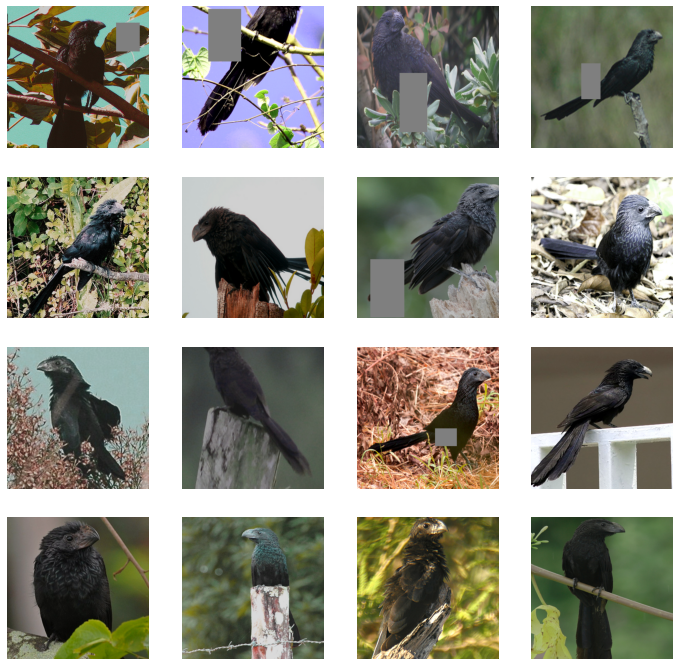

In [55]:
_, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()
image_batch, label_batch = next(iter(train_loader))
for i, image in enumerate(image_batch):
    if i == 16: break
    axes[i].axis('off')
    axes[i].imshow(image.squeeze().permute(1, 2, 0)*np.array(std) + np.array(mean))

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [59]:
for g in optimizer.param_groups:
    g['lr'] = 5e-3

In [60]:
best_accuracy = 0.

for epoch in range(1, 400+1):
    print('\nEpoch', epoch)
    
    model.train()
    
    total_loss = 0.0
    num_samples = 0.0
    correct = []
    for i, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.size(0)
        num_samples += data.size(0)
        correct.append(output.argmax(dim=1) == target)
                
    correct = torch.cat(correct, dim=0)
    accuracy = correct.double().mean().item()
    total_loss /= num_samples
    train_loss = total_loss
    train_accuracy = accuracy
        
    with torch.no_grad():
        total_loss = 0.0
        num_samples = 0.0
        correct = []
        model.eval()
        for i, (data, target) in enumerate(val_loader):

            data = data.to(device)
            target = target.to(device)
        
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
        
            total_loss += loss.item() * data.size(0)
            num_samples += data.size(0)
            correct.append(output.argmax(dim=1) == target)
                
        correct = torch.cat(correct, dim=0)
        accuracy = correct.double().mean().item()
        best_accuracy = max(best_accuracy, accuracy)
        total_loss /= num_samples
        
        print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
        print(f'Valid loss: {total_loss:.4f}, Valid accuracy: {accuracy:.4f}')
        print(f'Best accuracy so far: {best_accuracy:.4f}')


Epoch 1
Train loss: 0.1517, Train accuracy: 0.9492
Valid loss: 0.5128, Valid accuracy: 0.8750
Best accuracy so far: 0.8750

Epoch 2
Train loss: 1.1629, Train accuracy: 0.7813
Valid loss: 0.8229, Valid accuracy: 0.8300
Best accuracy so far: 0.8750

Epoch 3
Train loss: 1.3407, Train accuracy: 0.6628
Valid loss: 0.9347, Valid accuracy: 0.8225
Best accuracy so far: 0.8750

Epoch 4
Train loss: 1.9272, Train accuracy: 0.5664
Valid loss: 0.9280, Valid accuracy: 0.7725
Best accuracy so far: 0.8750

Epoch 5
Train loss: 1.4599, Train accuracy: 0.6081
Valid loss: 0.6705, Valid accuracy: 0.8250
Best accuracy so far: 0.8750

Epoch 6
Train loss: 1.1610, Train accuracy: 0.6810
Valid loss: 0.4556, Valid accuracy: 0.8725
Best accuracy so far: 0.8750

Epoch 7
Train loss: 0.5361, Train accuracy: 0.8229
Valid loss: 0.5312, Valid accuracy: 0.8550
Best accuracy so far: 0.8750

Epoch 8
Train loss: 0.6791, Train accuracy: 0.7969
Valid loss: 0.3084, Valid accuracy: 0.8850
Best accuracy so far: 0.8850

Epoch 9

KeyboardInterrupt: 

In [58]:
torch.save(model.state_dict(), '/kaggle/working/vit.pth')